<a href="https://colab.research.google.com/github/surucuonur/Data_Processing/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prediction using GridSearch Algorithm

Installing some essential libraries

In [1]:
# Install all necessary modules
!pip install pandas numpy plotly python-binance pykalman matplotlib scikit-learn keras mysql-connector

# Install TA-lib module
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 235kB 13.6MB/s 
     |████████████████████████████████| 11.9MB 15.3MB/s 
     |████████████████████████████████| 286kB 57.5MB/s 
     |████████████████████████████████| 112kB 61.9MB/s 
     |████████████████████████████████| 184kB 62.0MB/s 
     |████████████████████████████████| 1.3MB 28.2MB/s 
     |████████████████████████████████| 296kB 57.1MB/s 
     |████████████████████████████████| 143kB 61.7MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp37-none-any.whl size=48464 sha256=db4319ddf02450c5f43bbc237da53940ea829d801751d4879a997f6c1bc9d632
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247949 sha256=1db99289563505ce3b58c386bab9b936a7f3772298b0c70399f61840da4b58dd
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1

In [2]:
# ------Importing the Libraries-----
# Import global libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Import local libraries
from stats.Indicator import Indicators
from binance.client import Client
from AWS_database import Database
from Preprocessing import Scale, Time_domain, Filters, Frequency_domain, Time_frequency
from pykalman import KalmanFilter
from sklearn.preprocessing import StandardScaler

# Machine Learning Libraries
from sklearn.model_selection import KFold, GridSearchCV
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

## Database

In [11]:
db = Database("cryptocurrency")
df_btc = db.table_full_to_df("DOGEUSDT")
df_btc = df_btc.drop(columns=["close_time"]).set_index("open_date")
btc_dataset = df_btc.to_numpy()

In [12]:
def plot_data(fig, x_axis, y_axis, label_name, title="ETH Close Price Chart"):
    fig.add_trace(go.Scatter(x=x_axis, y=y_axis, mode="lines", name=label_name))
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Price ($)",
        autosize=False,
        width=800,
        height=600,
        margin=dict(l=40, r=40, b=40, t=40),
    )  # Adjust the size of the graph
    fig.update_xaxes(showgrid=False)  # Removing the grids
    fig.update_yaxes(showgrid=False)  # Removing the
    return fig


fig = go.Figure()
fig = plot_data(fig, df_btc.index, df_btc.close, "eth_close")
fig.show()

## Preprocessing the Dataset

In [13]:
# Adding Indicators in training dataset

# Create empty array for indicators
indicators = np.empty((btc_dataset.shape[0], 5))

# Calculate the indicators
indicator = Indicators(df_btc)
indicators[:,0] = indicator.SMA(50)
indicators[:,1] = indicator.SMA(200)
indicators[:,2] = indicator.RSI(time_interval=50)
indicators[:,3], indicators[:,4] = indicator.MACD()

# Fill Nans as 0 
where_are_NaNs = np.isnan(indicators)
indicators[where_are_NaNs] = 0

# Add indicators to the dataset
btc_dataset = np.hstack((btc_dataset,indicators))
print("Dataset shape:", btc_dataset.shape)

Dataset shape: (7469, 15)


In [14]:
# -------------SCALING-------------
# fit and transform the data
scaler = StandardScaler()
# fit and transform the data
btc_scaled = scaler.fit_transform(btc_dataset)


scaler_closed = StandardScaler()
scaler_closed.fit(btc_dataset[:, 4].reshape(-1, 1))

fig = go.Figure()
fig = plot_data(
    fig, df_btc.index, btc_scaled[:, 5].flatten(), "btc_closed (Standardized)", title="BTC Volume Chart"
)
fig.show()


In [15]:
# Creating a data structure with 90 timestamps and 1 output
X = []
y = []
n_future = 20  # Number of days we want top predict into the future
n_past = 60  # Number of past days we want to use to predict the future

for i in range(n_past, len(btc_scaled) - n_future + 1):
    X.append(btc_scaled[i - n_past : i, :])
    y.append(btc_scaled[i + n_future - 1 : i + n_future, 4])

X, y = np.array(X), np.array(y)       #Convert list to array

# Initialize train and test sets
X_test = X[-100:, :, :]
y_test = y[-100:,:]
X_train = X[:-100, :, :]
y_train = y[:-100,:]

# Pirnt out test and train set's shapes
print("X_train shape == {}.".format(X_train.shape))
print("y_train shape == {}.".format(y_train.shape))
print("X_test  shape == {}.".format(X_test.shape))
print("y_test  shape == {}.".format(y_test.shape))

X_train shape == (7290, 60, 15).
y_train shape == (7290, 1).
X_test  shape == (100, 60, 15).
y_test  shape == (100, 1).


## Training the LSTM model without tuning the hyperparameters

In [ ]:
import keras

model = Sequential()
model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))
model.add(
    LSTM(
        units=15,
        return_sequences=True,
        input_shape=X_train.shape[1:],
    )
)
model.add(LSTM(units=17, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(
    loss="mean_squared_error", optimizer=optimizer, metrics="mean_squared_error")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/100
365/365 [==============================] - 27s 56ms/step - loss: 0.1081 - mean_squared_error: 0.1081 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/100
365/365 [==============================] - 19s 52ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 3/100
365/365 [==============================] - 19s 51ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 4/100
365/365 [==============================] - 19s 52ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 5/100
365/365 [==============================] - 19s 52ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 6/100
365/365 [==============================] - 19s 52ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 7/10

## Result Analysis

### MSE values over epoch

In [ ]:
# MSE over the epochs
plt.plot(history.history["val_mean_squared_error"])

### Prediction of the model

In [ ]:
# Plot the prediction
predict_num = y_test.shape[0]

prediction = model.predict(X_test)
prediction_org = scaler_closed.inverse_transform(prediction)

fig = go.Figure()
fig = plot_data(fig, np.arange(btc_dataset.shape[0]), btc_dataset[:, 4], "BTC Close")

"""
X_train [row, [n+row --> n+window_len+row], features]
y_train [n + window_len + future + row]


example:
n_past: 60
n_future: 20
[100-160] [180]  row:100
"""

# X_train.shape[0]: the first value of the window (row)
# n_past: by adding n_past, goes to the last window
# n_future: by adding n_future, goes to the output
# + 1: jumps to the test set
prediction_start = X_train.shape[0] + n_past + n_future + 1
prediction_finish = prediction_start + predict_num



fig = plot_data(
    fig,
    np.arange(prediction_start,prediction_finish),
    prediction_org.flatten()
    + (btc_dataset[prediction_start, 4] - prediction_org[0, :]),
    "Prediction",
)

fig.add_shape(type="line",
    x0=prediction_start, y0=0, x1=prediction_start+ 1, y1=70000,
    line=dict(
        color="MediumPurple",
        width=1,
        dash="dot",
    )
)

fig.show()

## LSTM model with GridSearch Tuning

In [ ]:
# LSTM model with gridsearch 
def LSTM_model(neuron_layer1=10, neuron_layer2=5):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=X_train.shape[1:]))
    model.add(
        LSTM(
            units=15,
            return_sequences=True,
            input_shape=X_train.shape[1:],
        )
    )
    model.add(LSTM(units=10, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(
        loss="mean_squared_error", optimizer=optimizer, metrics="mean_squared_error"
    )

    return model


# activation = ["relu", "tanh", "sigmoid"]
# dropout_rate = [0, 0.2, 0.5, 0.7]
neuron_layer1 = [10, 15, 20, 25]
neuron_layer2 = [5, 10, 15, 20]
#batch_size = [20, 60, 100]

param_grid = dict(
    #batch_size=batch_size,
    # epochs=epochs,
    # activation=activation,
    # dropout_rate=dropout_rate,
    neuron_layer1=neuron_layer1,
    neuron_layer2=neuron_layer2,
)

model = KerasRegressor(build_fn=LSTM_model, epochs=20, verbose=1)
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=KFold(random_state=10),
    verbose=10,
    scoring="neg_mean_squared_error",
    error_score="raise",
)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [ ]:
# Start grid search for our algorithm
grid_results = grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] neuron_layer1=10, neuron_layer2=5 ...............................
Epoch 1/20
183/183 [==============================] - 18s 57ms/step - loss: 0.4796 - mean_squared_error: 0.4796
Epoch 2/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0826 - mean_squared_error: 0.0826
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0741 - mean_squared_error: 0.0741
Epoch 4/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0625 - mean_squared_error: 0.0625
Epoch 5/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 6/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0538 - mean_squared_error: 0.0538
Epoch 8/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0576 -

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 17s 56ms/step - loss: 0.3218 - mean_squared_error: 0.3218
Epoch 2/20
183/183 [==============================] - 10s 56ms/step - loss: 0.0726 - mean_squared_error: 0.0726
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0728 - mean_squared_error: 0.0728
Epoch 4/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0734 - mean_squared_error: 0.0734
Epoch 5/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0670 - mean_squared_error: 0.0670
Epoch 6/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0604 - mean_squared_error: 0.0604
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0614 - mean_squared_error: 0.0614
Epoch 8/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 9/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0591 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.4min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 17s 57ms/step - loss: 0.2369 - mean_squared_error: 0.2369
Epoch 2/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0689 - mean_squared_error: 0.0689
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0665 - mean_squared_error: 0.0665
Epoch 4/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0670 - mean_squared_error: 0.0670
Epoch 5/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0533 - mean_squared_error: 0.0533
Epoch 6/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0582 - mean_squared_error: 0.0582
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0564 - mean_squared_error: 0.0564
Epoch 8/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0569 - mean_squared_error: 0.0569
Epoch 9/20
183/183 [==============================] - 11s 57ms/step - loss: 0.0543 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 17s 58ms/step - loss: 0.4548 - mean_squared_error: 0.4548
Epoch 2/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0755 - mean_squared_error: 0.0755
Epoch 3/20
183/183 [==============================] - 11s 59ms/step - loss: 0.0710 - mean_squared_error: 0.0710
Epoch 4/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0592 - mean_squared_error: 0.0592
Epoch 5/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0592 - mean_squared_error: 0.0592
Epoch 6/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0612 - mean_squared_error: 0.0612
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0564 - mean_squared_error: 0.0564
Epoch 8/20
183/183 [==============================] - 11s 57ms/step - loss: 0.0600 - mean_squared_error: 0.0600
Epoch 9/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0569 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.9min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 17s 57ms/step - loss: 0.0862 - mean_squared_error: 0.0862
Epoch 2/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 3/20
183/183 [==============================] - 11s 57ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 4/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0305 - mean_squared_error: 0.0305
Epoch 5/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 6/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 7/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 8/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0235 - mean_squared_error: 0.0235
Epoch 9/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0223 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.6min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 18s 58ms/step - loss: 0.3688 - mean_squared_error: 0.3688
Epoch 2/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0822 - mean_squared_error: 0.0822
Epoch 3/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0653 - mean_squared_error: 0.0653
Epoch 4/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0623 - mean_squared_error: 0.0623
Epoch 5/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0684 - mean_squared_error: 0.0684
Epoch 6/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0611 - mean_squared_error: 0.0611
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0609 - mean_squared_error: 0.0609
Epoch 8/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0551 - mean_squared_error: 0.0551
Epoch 9/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0526 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 22.3min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 17s 58ms/step - loss: 0.4441 - mean_squared_error: 0.4441
Epoch 2/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0801 - mean_squared_error: 0.0801
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0710 - mean_squared_error: 0.0710
Epoch 4/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0648 - mean_squared_error: 0.0648
Epoch 5/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 6/20
183/183 [==============================] - 11s 57ms/step - loss: 0.0625 - mean_squared_error: 0.0625
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 8/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0561 - mean_squared_error: 0.0561
Epoch 9/20
183/183 [==============================] - 11s 59ms/step - loss: 0.0531 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 26.1min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 17s 56ms/step - loss: 0.4226 - mean_squared_error: 0.4226
Epoch 2/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0845 - mean_squared_error: 0.0845
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0777 - mean_squared_error: 0.0777
Epoch 4/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0631 - mean_squared_error: 0.0631
Epoch 5/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0638 - mean_squared_error: 0.0638
Epoch 6/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0596 - mean_squared_error: 0.0596
Epoch 7/20
183/183 [==============================] - 11s 57ms/step - loss: 0.0577 - mean_squared_error: 0.0577
Epoch 8/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0632 - mean_squared_error: 0.0632
Epoch 9/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0565 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 29.8min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 18s 58ms/step - loss: 0.4008 - mean_squared_error: 0.4008
Epoch 2/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0783 - mean_squared_error: 0.0783
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0661 - mean_squared_error: 0.0661
Epoch 4/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 5/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0614 - mean_squared_error: 0.0614
Epoch 6/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 7/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 8/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 9/20
183/183 [==============================] - 11s 59ms/step - loss: 0.0569 - mean_squared_error:

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 33.6min remaining:    0.0s


Epoch 1/20
183/183 [==============================] - 18s 58ms/step - loss: 0.1240 - mean_squared_error: 0.1240
Epoch 2/20
183/183 [==============================] - 11s 59ms/step - loss: 0.0389 - mean_squared_error: 0.0389
Epoch 3/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 4/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 5/20
183/183 [==============================] - 11s 58ms/step - loss: 0.0273 - mean_squared_error: 0.0273
Epoch 6/20
183/183 [==============================] - 10s 57ms/step - loss: 0.0254 - mean_squared_error: 0.0254
Epoch 7/20
183/183 [==============================] - 11s 59ms/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 8/20
183/183 [==============================] - 11s 60ms/step - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 9/20
183/183 [==============================] - 11s 59ms/step - loss: 0.0226 - mean_squared_error:

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 334.9min finished


Epoch 1/20
228/228 [==============================] - 21s 62ms/step - loss: 0.3378 - mean_squared_error: 0.3378
Epoch 2/20
228/228 [==============================] - 14s 63ms/step - loss: 0.0711 - mean_squared_error: 0.0711
Epoch 3/20
228/228 [==============================] - 14s 63ms/step - loss: 0.0605 - mean_squared_error: 0.0605
Epoch 4/20
228/228 [==============================] - 14s 62ms/step - loss: 0.0586 - mean_squared_error: 0.0586
Epoch 5/20
228/228 [==============================] - 14s 62ms/step - loss: 0.0554 - mean_squared_error: 0.0554
Epoch 6/20
228/228 [==============================] - 14s 62ms/step - loss: 0.0536 - mean_squared_error: 0.0536
Epoch 7/20
228/228 [==============================] - 14s 63ms/step - loss: 0.0528 - mean_squared_error: 0.0528
Epoch 8/20
228/228 [==============================] - 14s 62ms/step - loss: 0.0505 - mean_squared_error: 0.0505
Epoch 9/20
228/228 [==============================] - 15s 64ms/step - loss: 0.0527 - mean_squared_error:

In [ ]:
# Summarize the results in a readable format
print(
    "Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_)
)

means = grid_results.cv_results_["mean_test_score"]
stds = grid_results.cv_results_["std_test_score"]
params = grid_results.cv_results_["params"]

for mean, stdev, param in zip(means, stds, params):
    print("{0} ({1}) with: {2}".format(mean, stdev, param))

Best: -0.49756453599633604, using {'neuron_layer1': 15, 'neuron_layer2': 15}
-0.504989101590364 (0.8376173125592989) with: {'neuron_layer1': 10, 'neuron_layer2': 5}
-0.5786099969743919 (0.9331623911679764) with: {'neuron_layer1': 10, 'neuron_layer2': 10}
-0.5073707169859413 (0.8723991589208923) with: {'neuron_layer1': 10, 'neuron_layer2': 15}
-0.5795679279660442 (1.0026075499518827) with: {'neuron_layer1': 10, 'neuron_layer2': 20}
-0.8355158699390369 (1.5438398398202535) with: {'neuron_layer1': 15, 'neuron_layer2': 5}
-0.6304358897717337 (1.106935694619682) with: {'neuron_layer1': 15, 'neuron_layer2': 10}
-0.49756453599633604 (0.8231287356166904) with: {'neuron_layer1': 15, 'neuron_layer2': 15}
-0.5672010400518309 (0.9617226389181742) with: {'neuron_layer1': 15, 'neuron_layer2': 20}
-0.686918106160428 (1.13962319982887) with: {'neuron_layer1': 20, 'neuron_layer2': 5}
-0.7858963764895684 (1.4094389498505933) with: {'neuron_layer1': 20, 'neuron_layer2': 10}
-0.6319087611566724 (1.0668884

AttributeError: ignored

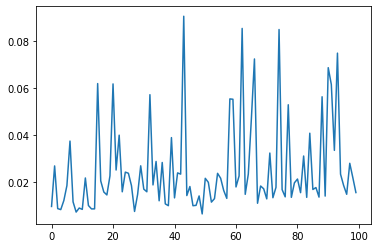

In [ ]:
plt.plot(history.history["val_mean_squared_error"])
prediction = model.predict(X_train[-n_past:])


In [ ]:
prediction_org = scaler_closed.inverse_transform(prediction)

fig = go.Figure()
fig = plot_data(fig, np.arange(btc_dataset.shape[0]), btc_dataset[:, 4], "BTC Close")


fig = plot_data(
    fig,
    np.arange(X_train[:-20].shape[0], X_train.shape[0]),
    prediction_org.flatten()
    + (btc_dataset[X_train[:-20].shape[0], 4] - prediction_org[0, :]),
    "Prediction",
)

fig.show()